In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sentence_transformers import SentenceTransformer

import utils

In [2]:
patent_data = utils.load_patent_data('../data/uspto.xlsx', 'patent_data')

In [3]:
patent_data

,TITLE,CPC,ASIGNEE,FILING_DATE,YEAR,PATENT_NO,CATEGORY,SUB_CATEGORY,TAXONOMY_SSTT,SECTION
0,SYSTEMS AND METHODS FOR STRUCTURE DISCOVERY AN...,G06F40/289;G06F40/40;G06F16/33;G06F40/279;G06F...,"CASETEXT, INC.",2023-06-29,2023,11861321,ARTIFICIAL INTELLIGENCE,INFORMATION AND SIGNAL PROCESSING TECHNOLOGIES,A09,A
1,"FREQUENCY SEPARATOR, OPTICAL QUANTIZATION CIRC...",G02F1/01;G02F2/006;G02F7/00,MITSUBISHI ELECTRIC CORPORATION,2023-06-27,2023,20230350269,ARTIFICIAL INTELLIGENCE,INFORMATION AND SIGNAL PROCESSING TECHNOLOGIES,A09,A
2,MEDICAL STRUCTURED REPORTING WORKFLOW ASSISTED...,G06F40/174;G06N20/00;G16H50/20;G16H10/60;G16H1...,EBIT SRL,2023-06-27,2023,20240006039,ARTIFICIAL INTELLIGENCE,INFORMATION AND SIGNAL PROCESSING TECHNOLOGIES,A09,A
3,"SYSTEMS, METHODS, AND APPARATUSES FOR GENERATI...",G06F40/30;G06F16/34;G06F40/279;G06F21/6254;G06...,"PREMIER HEALTHCARE SOLUTIONS, INC.",2023-06-23,2023,20230418981,ARTIFICIAL INTELLIGENCE,INFORMATION AND SIGNAL PROCESSING TECHNOLOGIES,A09,A
4,NATURAL LANGUAGE PROCESSING FOR BLOCKCHAIN-BAS...,G06F16/289;G06F16/283;G06F16/24573;G06F16/27,NaN,2023-06-09,2023,20230409604,ARTIFICIAL INTELLIGENCE,INFORMATION AND SIGNAL PROCESSING TECHNOLOGIES,A09,A
...,...,...,...,...,...,...,...,...,...,...
8038,SYSTEMS AND METHODS FOR MONITORING AUTOMATED C...,B29C70/386;G01N21/88,THE BOEING COMPANY,2006-05-16,2006,20070277919,COMPOSITE,MANUFACTURING PROCESSES/ DESIGN TOOLS/ TECHNIQUES,B12,B
8039,PORTABLE COMPOSITE BONDING INSPECTION SYSTEM,G01N21/94,"SPACE MICRO, INC.",2007-04-23,2007,20070252084,COMPOSITE,MANUFACTURING PROCESSES/ DESIGN TOOLS/ TECHNIQUES,B12,B
8040,METHODS OF DEBONDING A COMPOSITE TOOLING,B29C70/30;B29C33/505;B64F5/10,"TOYOTA MOTOR SALES U.S.A., INC.",2006-07-21,2006,20070006960,COMPOSITE,MANUFACTURING PROCESSES/ DESIGN TOOLS/ TECHNIQUES,B12,B
8041,ADHESIVE OF A SILICON AND SILICA COMPOSITE FOR...,H01L21/67306,NaN,2006-06-01,2006,20060213601,COMPOSITE,MANUFACTURING PROCESSES/ DESIGN TOOLS/ TECHNIQUES,B12,B


In [4]:
patent_data['Cleaned_Title'] = patent_data['TITLE'].apply(utils.clean_text)
title_list = patent_data['Cleaned_Title'].tolist()

In [5]:
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

In [6]:
title_embeddings = model.encode(patent_data['Cleaned_Title'].tolist())

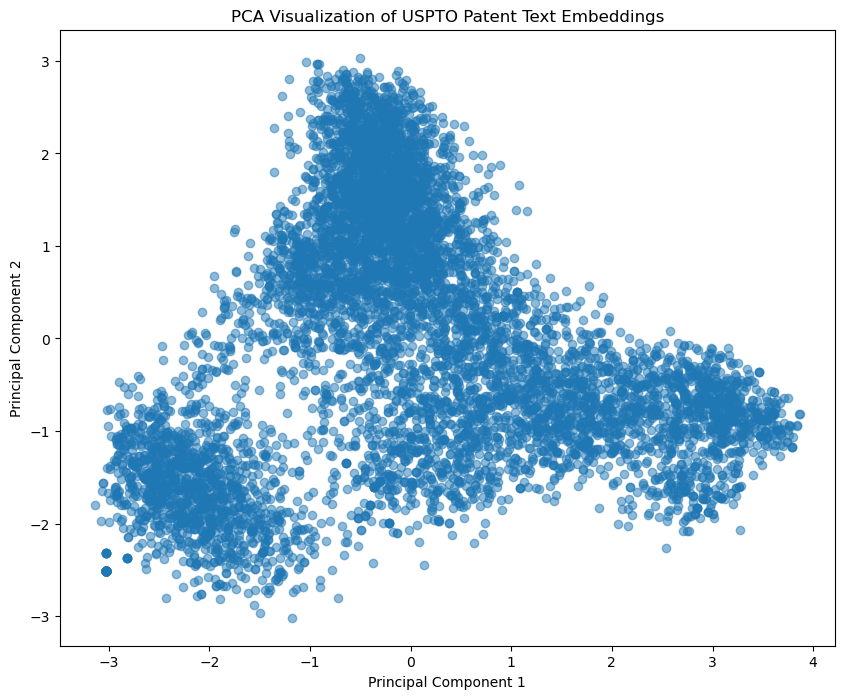

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA to reduce dimensionality
pca = PCA(n_components=2)
title_embeddings_pca = pca.fit_transform(title_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(title_embeddings_pca[:, 0], title_embeddings_pca[:, 1], alpha=0.5)
plt.title("PCA Visualization of USPTO Patent Text Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [8]:
# Save the embeddings
np.savetxt('title_embeddings.tsv', title_embeddings, delimiter='\t')

# Save the metadata (titles)
patent_data['Cleaned_Title'].to_csv('metadata.tsv', index=False, header=False)

# Create projector config file
config = """
embeddings {
  tensor_name: "title_embeddings"
  tensor_path: "title_embeddings.tsv"
  metadata_path: "metadata.tsv"
}
"""
with open('projector_config.pbtxt', 'w') as f:
    f.write(config)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

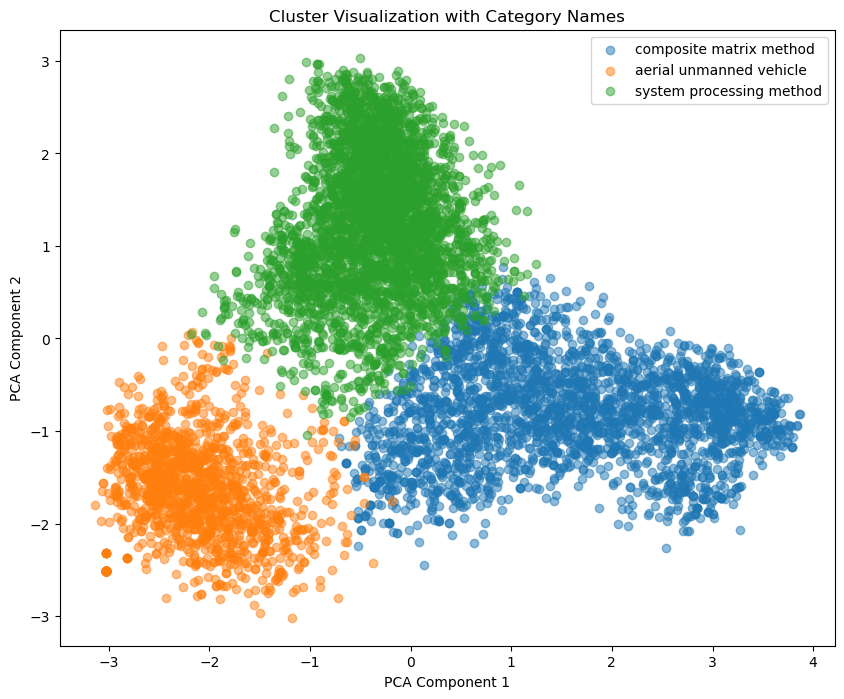

In [10]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from nltk.corpus import stopwords

# Step 1: Cluster the embedded text
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k)
cluster_labels = kmeans.fit_predict(title_embeddings)

# Step 2: Assign category names to clusters based on topic modeling
cluster_names = {}
stop_words = list(stopwords.words('english'))  # Convert English stop words to a list
for cluster_id in range(k):
    # Extract titles in the current cluster
    titles_in_cluster = np.array(title_list)[cluster_labels == cluster_id]
    
    # Use CountVectorizer to convert text into a matrix of token counts
    vectorizer = CountVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(titles_in_cluster)
    
    # Use Latent Dirichlet Allocation (LDA) for topic modeling
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)
    
    # Get the most probable words in the topics
    feature_names = vectorizer.get_feature_names_out()
    topic_words_idx = lda.components_[0].argsort()[-3:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    # Join the top words to form the category name
    category_name = ' '.join(topic_words)
    cluster_names[cluster_id] = category_name

# Step 3: Visualize the clusters with category names
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
title_embeddings_2d = pca.fit_transform(title_embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(k):
    plt.scatter(title_embeddings_2d[cluster_labels == cluster_id, 0], 
                title_embeddings_2d[cluster_labels == cluster_id, 1], 
                label=cluster_names[cluster_id], alpha=0.5)
plt.title("Cluster Visualization with Category Names")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

For n_clusters = 2, the average silhouette score is: 0.0737
For n_clusters = 3, the average silhouette score is: 0.0774
For n_clusters = 4, the average silhouette score is: 0.0811
For n_clusters = 5, the average silhouette score is: 0.0918
For n_clusters = 6, the average silhouette score is: 0.1013
For n_clusters = 7, the average silhouette score is: 0.1041
For n_clusters = 8, the average silhouette score is: 0.1122
For n_clusters = 9, the average silhouette score is: 0.1146
For n_clusters = 10, the average silhouette score is: 0.1178


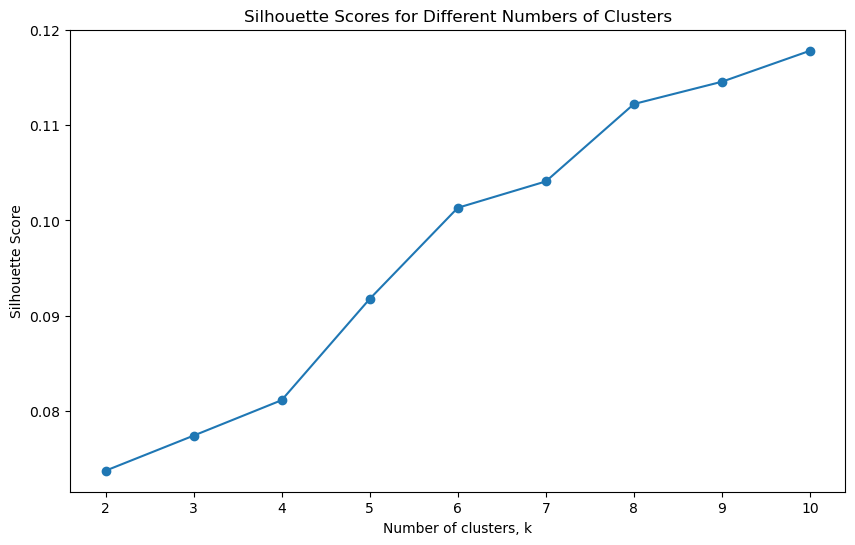

In [11]:
def evaluate_kmeans_clusters(title_embeddings, max_k=10):
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(title_embeddings)
        silhouette_avg = silhouette_score(title_embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {k}, the average silhouette score is: {silhouette_avg:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.show()

evaluate_kmeans_clusters(title_embeddings, max_k=10)

Silhouette score after PCA: 0.5619


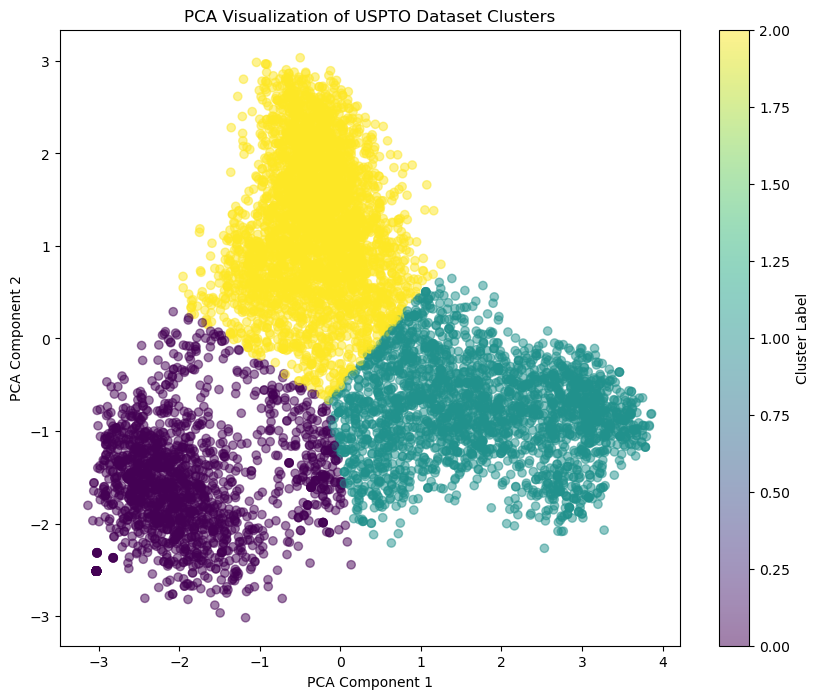

In [12]:
pca = PCA(n_components=2)
title_embeddings_pca = pca.fit_transform(title_embeddings)


kmeans_pca = KMeans(n_clusters=3, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(title_embeddings_pca)
silhouette_avg_pca = silhouette_score(title_embeddings_pca, cluster_labels_pca)
print(f"Silhouette score after PCA: {silhouette_avg_pca:.4f}")


plt.figure(figsize=(10, 8))
plt.scatter(title_embeddings_pca[:, 0], title_embeddings_pca[:, 1], c=cluster_labels_pca, cmap='viridis', alpha=0.5)
plt.title("PCA Visualization of USPTO Dataset Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

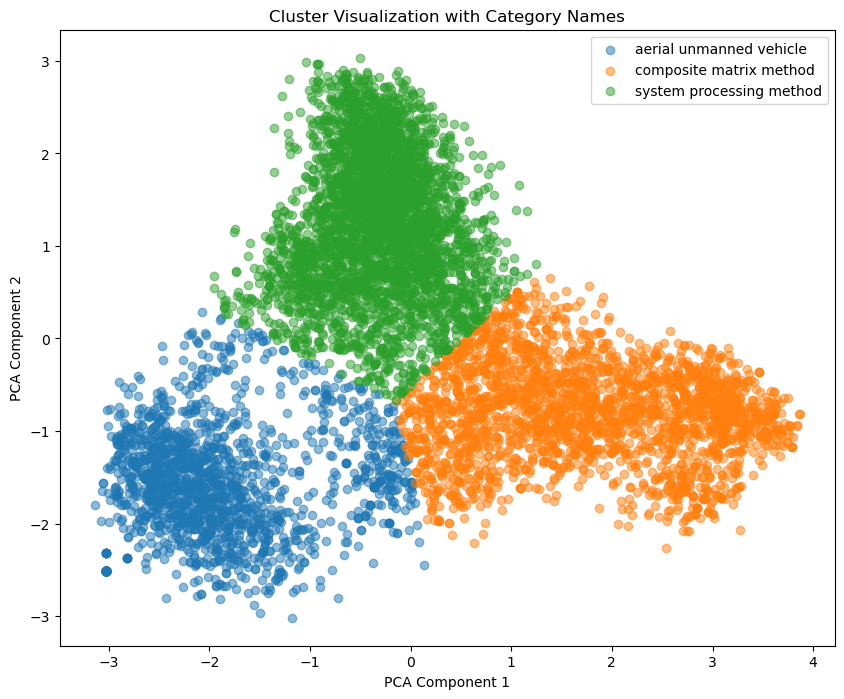

In [18]:
cluster_names = {}

for cluster_id in range(3):
    
    titles_in_cluster = np.array(title_list)[cluster_labels_pca == cluster_id]
    
    vectorizer = CountVectorizer(stop_words=stop_words)
    X = vectorizer.fit_transform(titles_in_cluster)
    
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X)
    
    feature_names = vectorizer.get_feature_names_out()
    topic_words_idx = lda.components_[0].argsort()[-3:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]

    category_name = ' '.join(topic_words)
    cluster_names[cluster_id] = category_name

plt.figure(figsize=(10, 8))
for cluster_id in range(3):
    plt.scatter(title_embeddings_pca[cluster_labels_pca == cluster_id, 0], 
                title_embeddings_pca[cluster_labels_pca == cluster_id, 1], 
                label=cluster_names[cluster_id], alpha=0.5)
plt.title("Cluster Visualization with Category Names")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

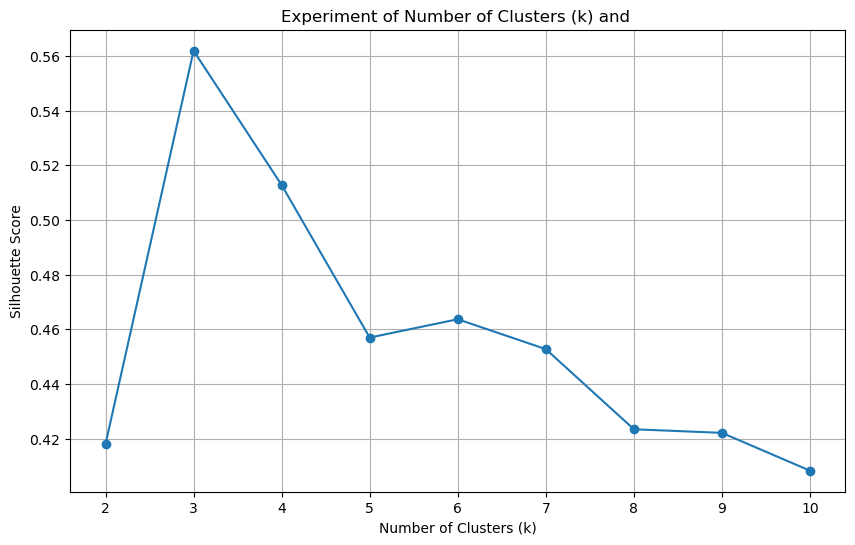

    k  Silhouette Score
0   2          0.417962
1   3          0.561887
2   4          0.512749
3   5          0.456942
4   6          0.463644
5   7          0.452706
6   8          0.423389
7   9          0.422076
8  10          0.408226


In [26]:
pca = PCA(n_components=2)
title_embeddings_pca = pca.fit_transform(title_embeddings)

k_values = range(2, 11)

results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(title_embeddings_pca)
    silhouette_avg = silhouette_score(title_embeddings_pca, cluster_labels)
    
    results.append({
        'k': k,
        'Silhouette Score': silhouette_avg
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['Silhouette Score'], marker='o')
plt.title('Experiment of Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

print(results_df)

In [148]:
query = 'Security Data Processing'

query_embedding = model.encode([query])
number_top_matches = 10000

print("Relevant Patents using Semantic Search:")
relevant_patents_df = utils.semantic_search(query, query_embedding, title_embeddings, patent_data, threshold=0.5, top_matches=number_top_matches,
                                      patent_id_col='Patent ID', pub_number_col='PATENT_NO',
                                      title_col='TITLE', abstract_col='ASIGNEE',
                                      date_col='FILING_DATE', cpc_col='CPC')

relevant_patents_df

Relevant Patents using Semantic Search:


,Patent ID,Score,PATENT_NO,TITLE,ASIGNEE,FILING_DATE,CPC
0,2740,0.868273,20090013016,SYSTEM AND METHOD FOR PROCESSING DATA FOR DATA...,"NEOSCALE SYSTEMS, INC.",2007-07-06,G06F21/6209
1,2103,0.809801,20200015088,DATA SECURITY PROCESSING METHOD AND APPARATUS,NaN,2019-09-19,H04W12/041;H04W36/0038;H04L63/06;H04L69/24;H04...
2,1863,0.779098,20230308451,DATA SECURITY,NaN,2023-03-29,H04W12/06;H04L67/55;H04L63/08;H04L63/1425;H04L...
3,2002,0.779098,20220164458,DATA SECURITY,NaN,2020-11-25,H04L9/0643;H04L9/3236;G06F21/64;H04L9/0897;G06...
4,2143,0.779098,20200410135,DATA SECURITY,BARCLAYS EXECUTION SERVICES LIMITED,2019-02-28,G06F18/23213;G06F18/211;G06Q30/0201;G06F21/6254
...,...,...,...,...,...,...,...
896,360,0.500677,20210209102,USING ARTIFICIAL INTELLIGENCE AND NATURAL LANG...,NaN,2020-01-07,G06N5/04;G06F16/256;G06F16/24522;G06F16/248;G0...
897,361,0.500677,20210209170,USING ARTIFICIAL INTELLIGENCE AND NATURAL LANG...,NaN,2020-01-07,G06F17/18;G06F18/22;G06Q10/10;G06Q10/063;H04L5...
898,1145,0.500483,11689554,MACHINE LEARNED NETWORK VULNERABILITY ASSESSMENT,"RAPID7, INC.",2021-08-02,H04L41/0866;H04L63/1433;G06F18/2411;G06F18/24;...
899,51,0.500410,20220383516,DEVICES AND METHODS FOR DIGITAL SIGNAL PROCESSING,NaN,2022-08-02,G06T7/248;G06T3/18;G06T5/70;G06T5/50


In [149]:
print("Number of Relevant Patents:", len(relevant_patents_df))

Number of Relevant Patents: 901


d:\Liftup\github\models\utils.py:71: FutureWarning: The default value of regex will change from True to False in a future version.
  relevant_patents_df[cpc_col] = relevant_patents_df[cpc_col].str.replace(r'[^A-Z0-9/]', '')


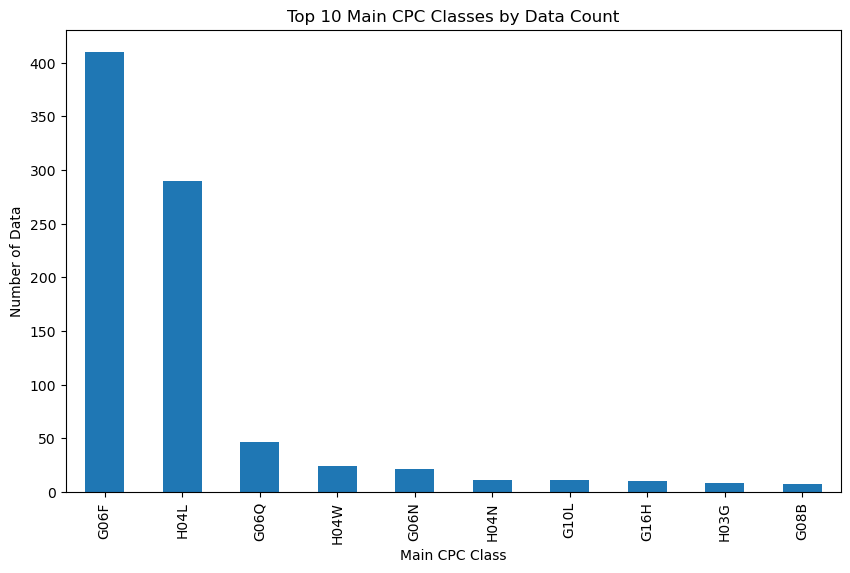

In [150]:
cpc_col = 'CPC'
cpc_counts = utils.preprocess_cpc_data(relevant_patents_df, cpc_col)
top_cpc_counts = cpc_counts.head(10)

plt.figure(figsize=(10, 6))
top_cpc_counts.plot(kind='bar')
plt.xlabel('Main CPC Class')
plt.ylabel('Number of Data')
plt.title('Top 10 Main CPC Classes by Data Count')
plt.show()

In [151]:
import numpy as np
from scipy.optimize import curve_fit

# def plot_s_curves(relevant_patents_df, cpc_counts, time_col, top_n=5, year_range=(1990, 2070), growth_model=None, growth_model_label=None):
#     if growth_model is None or growth_model_label is None:
#         raise ValueError("Both growth_model and growth_model_label must be specified.")
    
#     top_cpc_codes = cpc_counts.head(top_n).index
    
#     for cpc_code in top_cpc_codes:
#         cpc_relevant_patents = relevant_patents_df[relevant_patents_df['CPC'].str.contains(cpc_code)]
#         year_counts = cpc_relevant_patents.groupby(cpc_relevant_patents[time_col].dt.year).size()
        
#         if not year_counts.empty:
#             future_years = np.arange(*year_range)
#             patent_cumulative_counts = year_counts.cumsum()

#             try:
#                 initial_guess = (max(patent_cumulative_counts), 0.1, year_range[0])
#                 bounds = ([0, 0, year_range[0]], [np.inf, np.inf, np.inf])  # Set bounds for parameters
#                 popt, pcov = curve_fit(growth_model, patent_cumulative_counts.index, patent_cumulative_counts, p0=initial_guess, bounds=bounds)
#                 future_counts = growth_model(future_years, *popt)

#                 print(f"For CPC {cpc_code}: Estimated Parameters (a, b, c): {popt}")

#                 plt.figure(figsize=(10, 6))
#                 plt.plot(year_counts.index, year_counts.cumsum(), 'o', label=f'CPC {cpc_code} - Actual')
#                 if future_years is not None and future_counts is not None:
#                     plt.plot(future_years, future_counts, label=f'CPC {cpc_code} - Predicted')

#                 plt.xlabel('Years')
#                 plt.ylabel('Cumulative Number of Patents')
#                 plt.title(f'S-Curve for CPC {cpc_code} ({growth_model_label})')
#                 plt.legend()
#                 plt.grid(True)
#                 plt.show()
#             except (RuntimeError, ValueError) as e:
#                 print(f"Failed to fit {growth_model_label} growth model for CPC {cpc_code}: {e}")
#         else:
#             print(f"No data available for CPC {cpc_code}")

In [152]:
def logistic_growth(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

def plot_s_curves(relevant_patents_df, cpc_counts, time_col, top_n=5, year_range=(1990, 2050), growth_model=None, growth_model_label=None):
    if growth_model is None or growth_model_label is None:
        raise ValueError("Both growth_model and growth_model_label must be specified.")
    
    top_cpc_codes = cpc_counts.head(top_n).index
    
    for cpc_code in top_cpc_codes:
        cpc_relevant_patents = relevant_patents_df[relevant_patents_df['CPC'].str.contains(cpc_code)]
        year_counts = cpc_relevant_patents.groupby(cpc_relevant_patents[time_col].dt.year).size()
        
        if not year_counts.empty:
            future_years = np.arange(*year_range)
            patent_cumulative_counts = year_counts.cumsum()

            try:
                initial_guess = (max(patent_cumulative_counts), 0.1, year_range[0])
                bounds = ([0, 0, year_range[0]], [np.inf, np.inf, np.inf])  # Set bounds for parameters
                popt, pcov = curve_fit(growth_model, patent_cumulative_counts.index, patent_cumulative_counts, p0=initial_guess, bounds=bounds)
                future_counts = growth_model(future_years, *popt)

                print(f"For CPC {cpc_code}: Estimated Parameters (K, r, t0): {popt}")

                plt.figure(figsize=(10, 6))
                plt.plot(year_counts.index, year_counts.cumsum(), 'o', label=f'CPC {cpc_code} - Actual')
                if future_years is not None and future_counts is not None:
                    plt.plot(future_years, future_counts, label=f'CPC {cpc_code} - Predicted')

                plt.xlabel('Years')
                plt.ylabel('Cumulative Number of Patents')
                plt.title(f'S-Curve for CPC {cpc_code} ({growth_model_label})')
                plt.legend()
                plt.grid(True)
                plt.show()
            except (RuntimeError, ValueError) as e:
                print(f"Failed to fit {growth_model_label} growth model for CPC {cpc_code}: {e}")
        else:
            print(f"No data available for CPC {cpc_code}")

For CPC G06F: Estimated Parameters (K, r, t0): [8.74064914e+02 2.44243005e-01 2.01780037e+03]


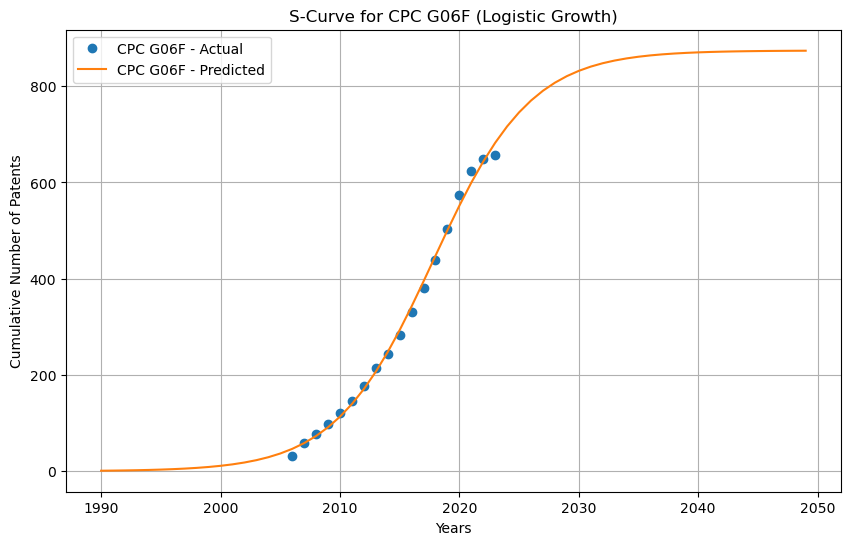

For CPC H04L: Estimated Parameters (K, r, t0): [5.97371492e+02 2.63857508e-01 2.01740961e+03]


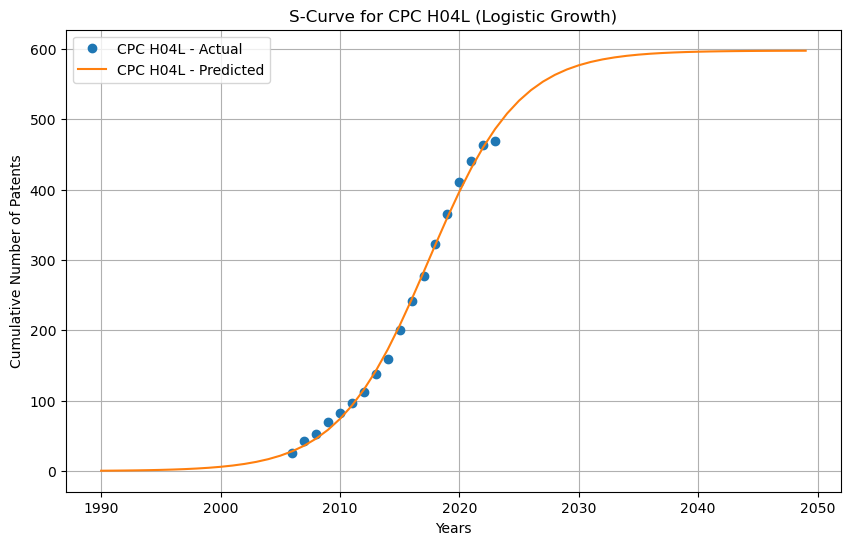

For CPC G06Q: Estimated Parameters (K, r, t0): [2.02844047e+02 1.86704923e-01 2.02224395e+03]


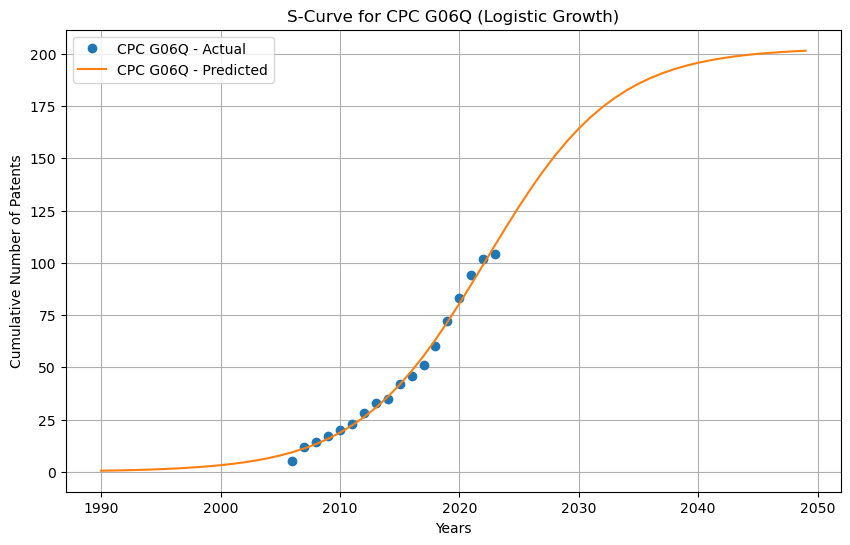

In [153]:
time_col = 'FILING_DATE'
plot_s_curves(relevant_patents_df, cpc_counts, time_col, top_n=3,growth_model=logistic_growth, growth_model_label="Logistic Growth")

In [154]:
# time_col = 'FILING_DATE'
# plot_s_curves(relevant_patents_df, cpc_counts, time_col, top_n=3, year_range=(1990, 2050), growth_model=utils.logistic_growth, growth_model_label="Logistic")

For CPC G06F: Estimated Parameters (K, r, t0): [1.46849993e+03 9.40292958e-02 2.01994559e+03]

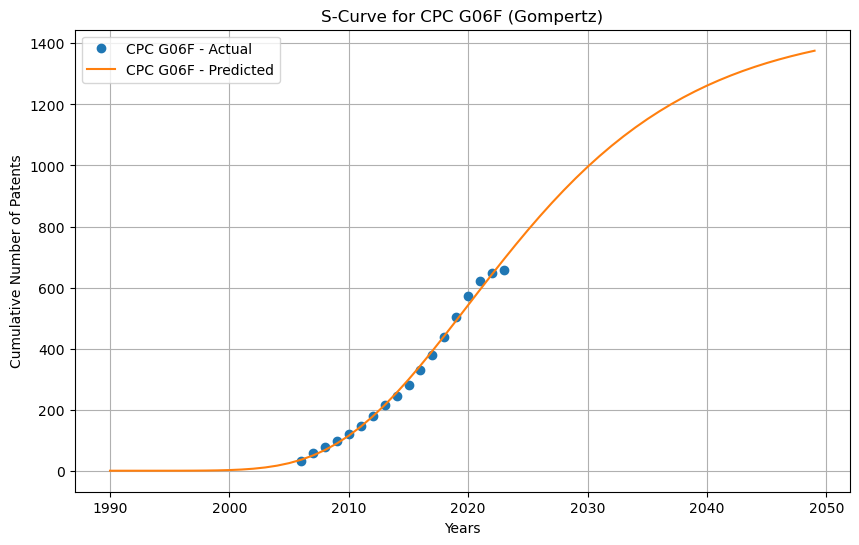

For CPC H04L: Estimated Parameters (K, r, t0): [9.71497406e+02 1.02590227e-01 2.01912470e+03]


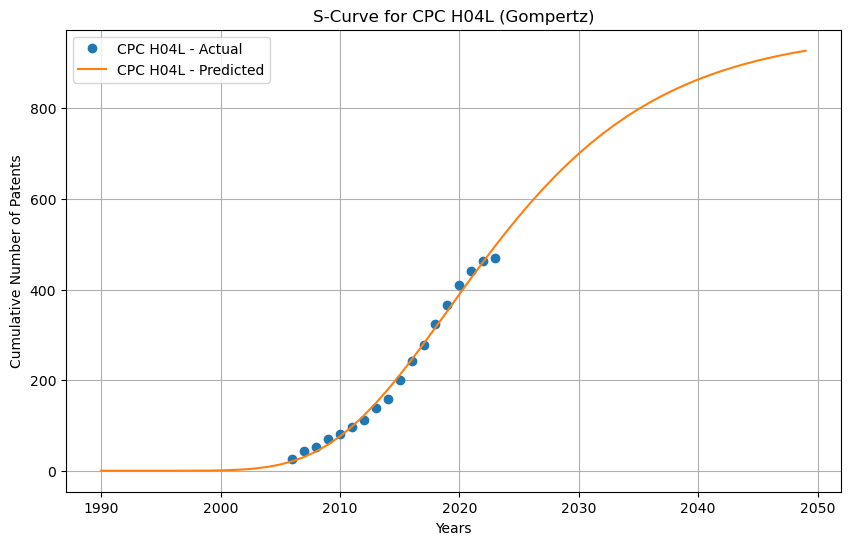

For CPC G06Q: Estimated Parameters (K, r, t0): [9.08303197e+02 4.65040659e-02 2.03911687e+03]


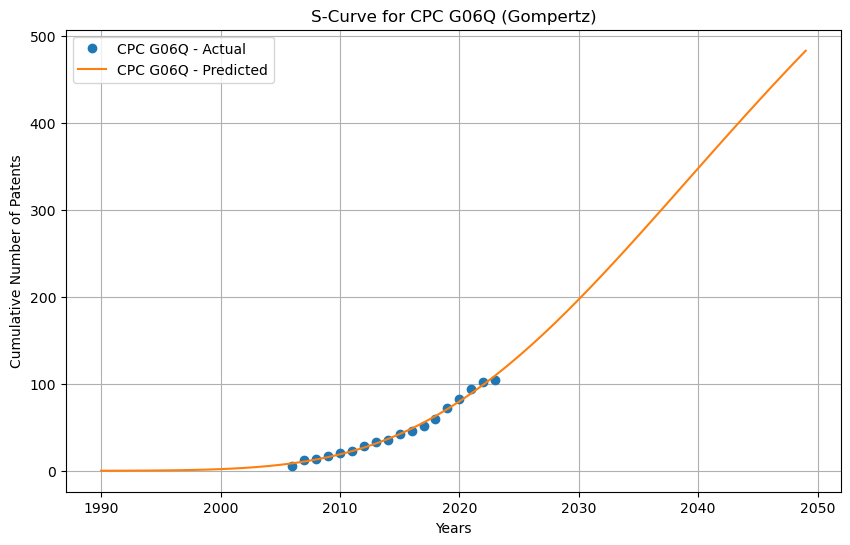

In [155]:
plot_s_curves(relevant_patents_df, cpc_counts, time_col, top_n=3, year_range=(1990, 2050), growth_model=utils.gompertz_growth, growth_model_label="Gompertz")